In [1]:


from utils.visualization import *

from utils.GlobalTrendAnalyzer import GlobalTrendAnalyzer

In [2]:
# 初始化模型加载器
model_loader = ModelLoader(model_path="checkpoints/best_models/best_model.pth")
print("模型加载完成")
print(f"数据集大小: {len(model_loader.dataset)}")
print(f"特征维度: {model_loader.feature_names}")

Loaded data shape: torch.Size([595, 6, 6])


C:\Users\rigel\anaconda3\envs\DEN_VAE\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
D:\Courses\MATH4225\group\DEN_VAE\utils\visualization.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializati

模型加载完成
数据集大小: 595
特征维度: ['AGI', 'ADI', 'POPN_D', 'LA', 'month', 'season_num']


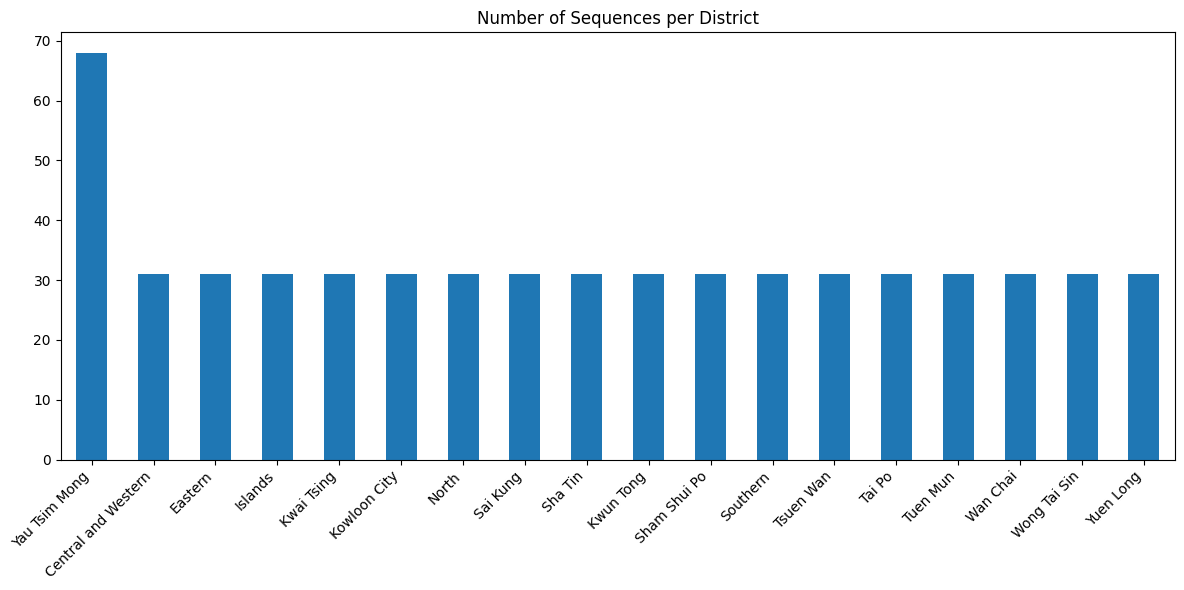

In [3]:
# 3. 查看数据分布
# 显示不同地区的数据分布
district_counts = pd.Series(model_loader.district_labels).value_counts()

plt.figure(figsize=(12, 6))
district_counts.plot(kind='bar')
plt.title('Number of Sequences per District')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

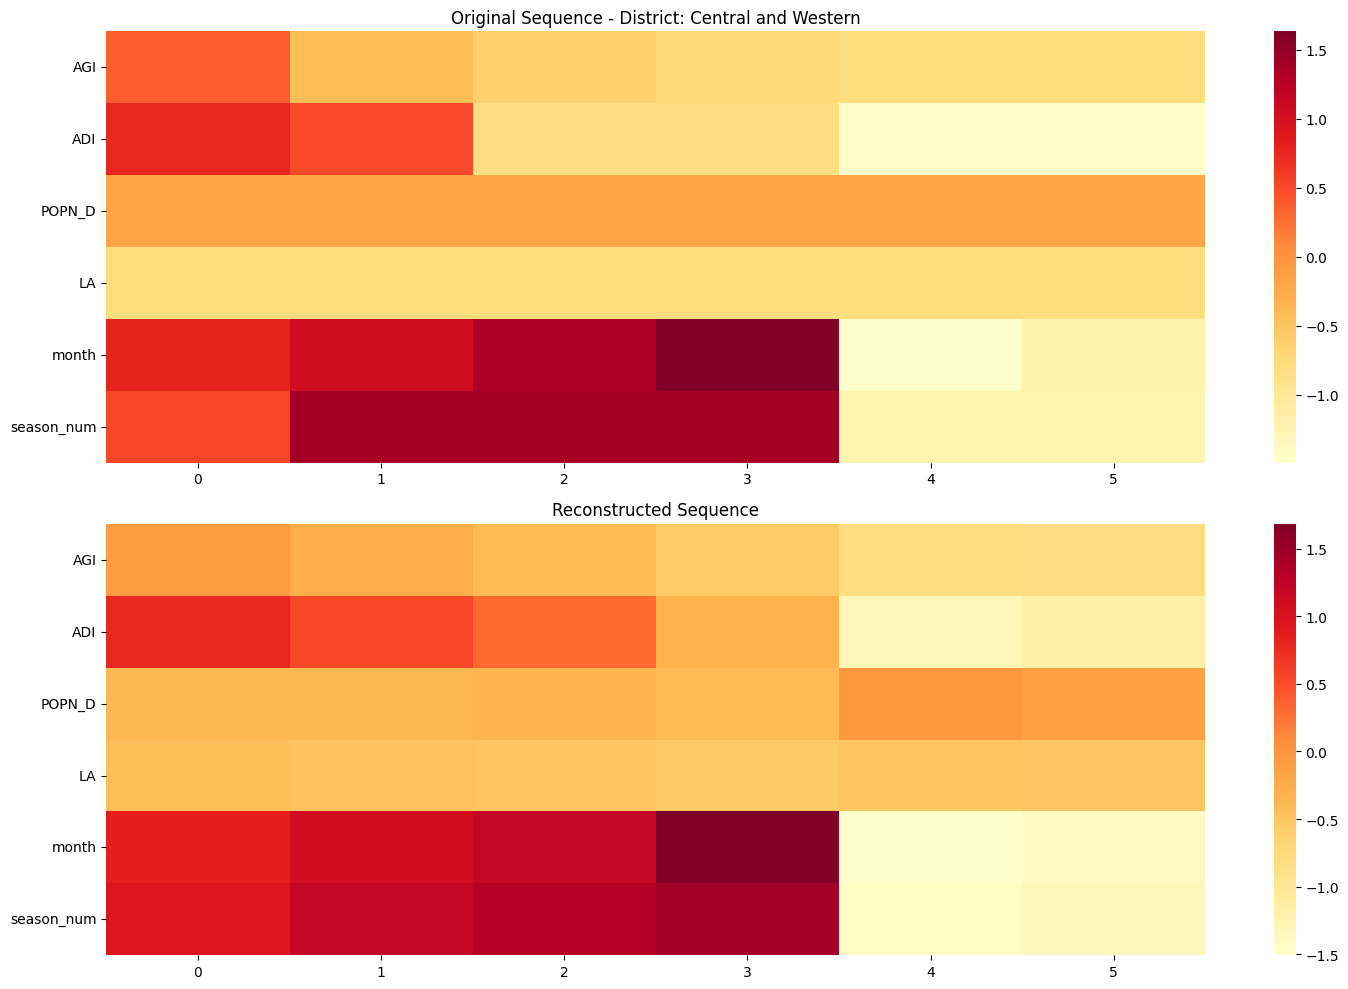

In [4]:
# 查看第一个序列
original, reconstruction = plot_sequence(0, model_loader)

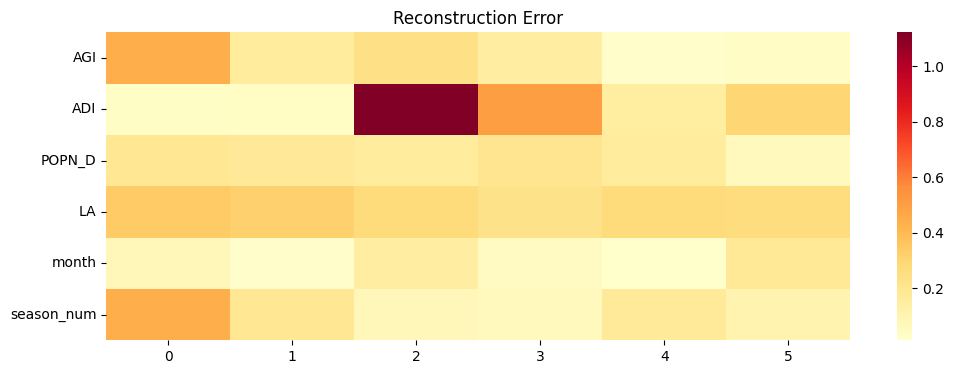


平均重建误差:


,Feature,Mean Error
1,ADI,0.359211
3,LA,0.283419
5,season_num,0.175391
0,AGI,0.174880
2,POPN_D,0.161352
4,month,0.083076


In [5]:
error_df = analyze_reconstruction_error(original, reconstruction, model_loader)
print("\n平均重建误差:")
display(error_df)

C:\Users\rigel\anaconda3\envs\DEN_VAE\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\rigel\anaconda3\envs\DEN_VAE\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\rigel\anaconda3\envs\DEN_VAE\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\rigel\anaconda3\envs\DEN_VAE\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\rigel\anaconda3\envs\DEN_VAE\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


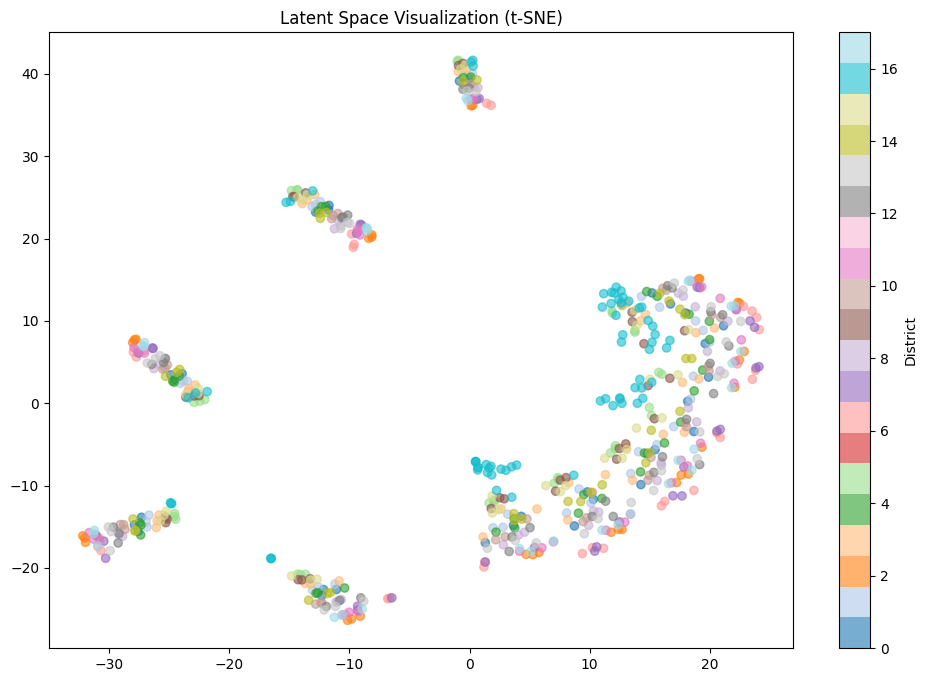

In [6]:
visualize_latent_space(model_loader, n_samples=1000)

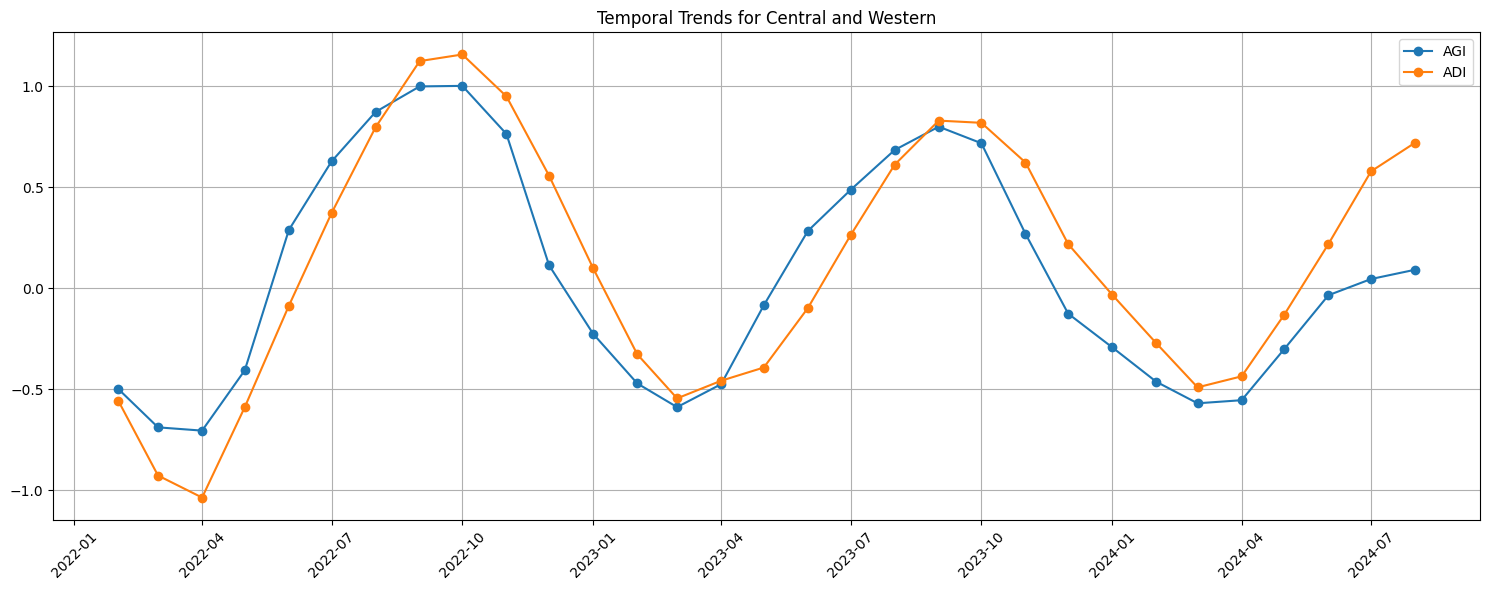

In [7]:
# 分析特定地区的时间趋势
analyze_temporal_trends("Central and Western", model_loader)

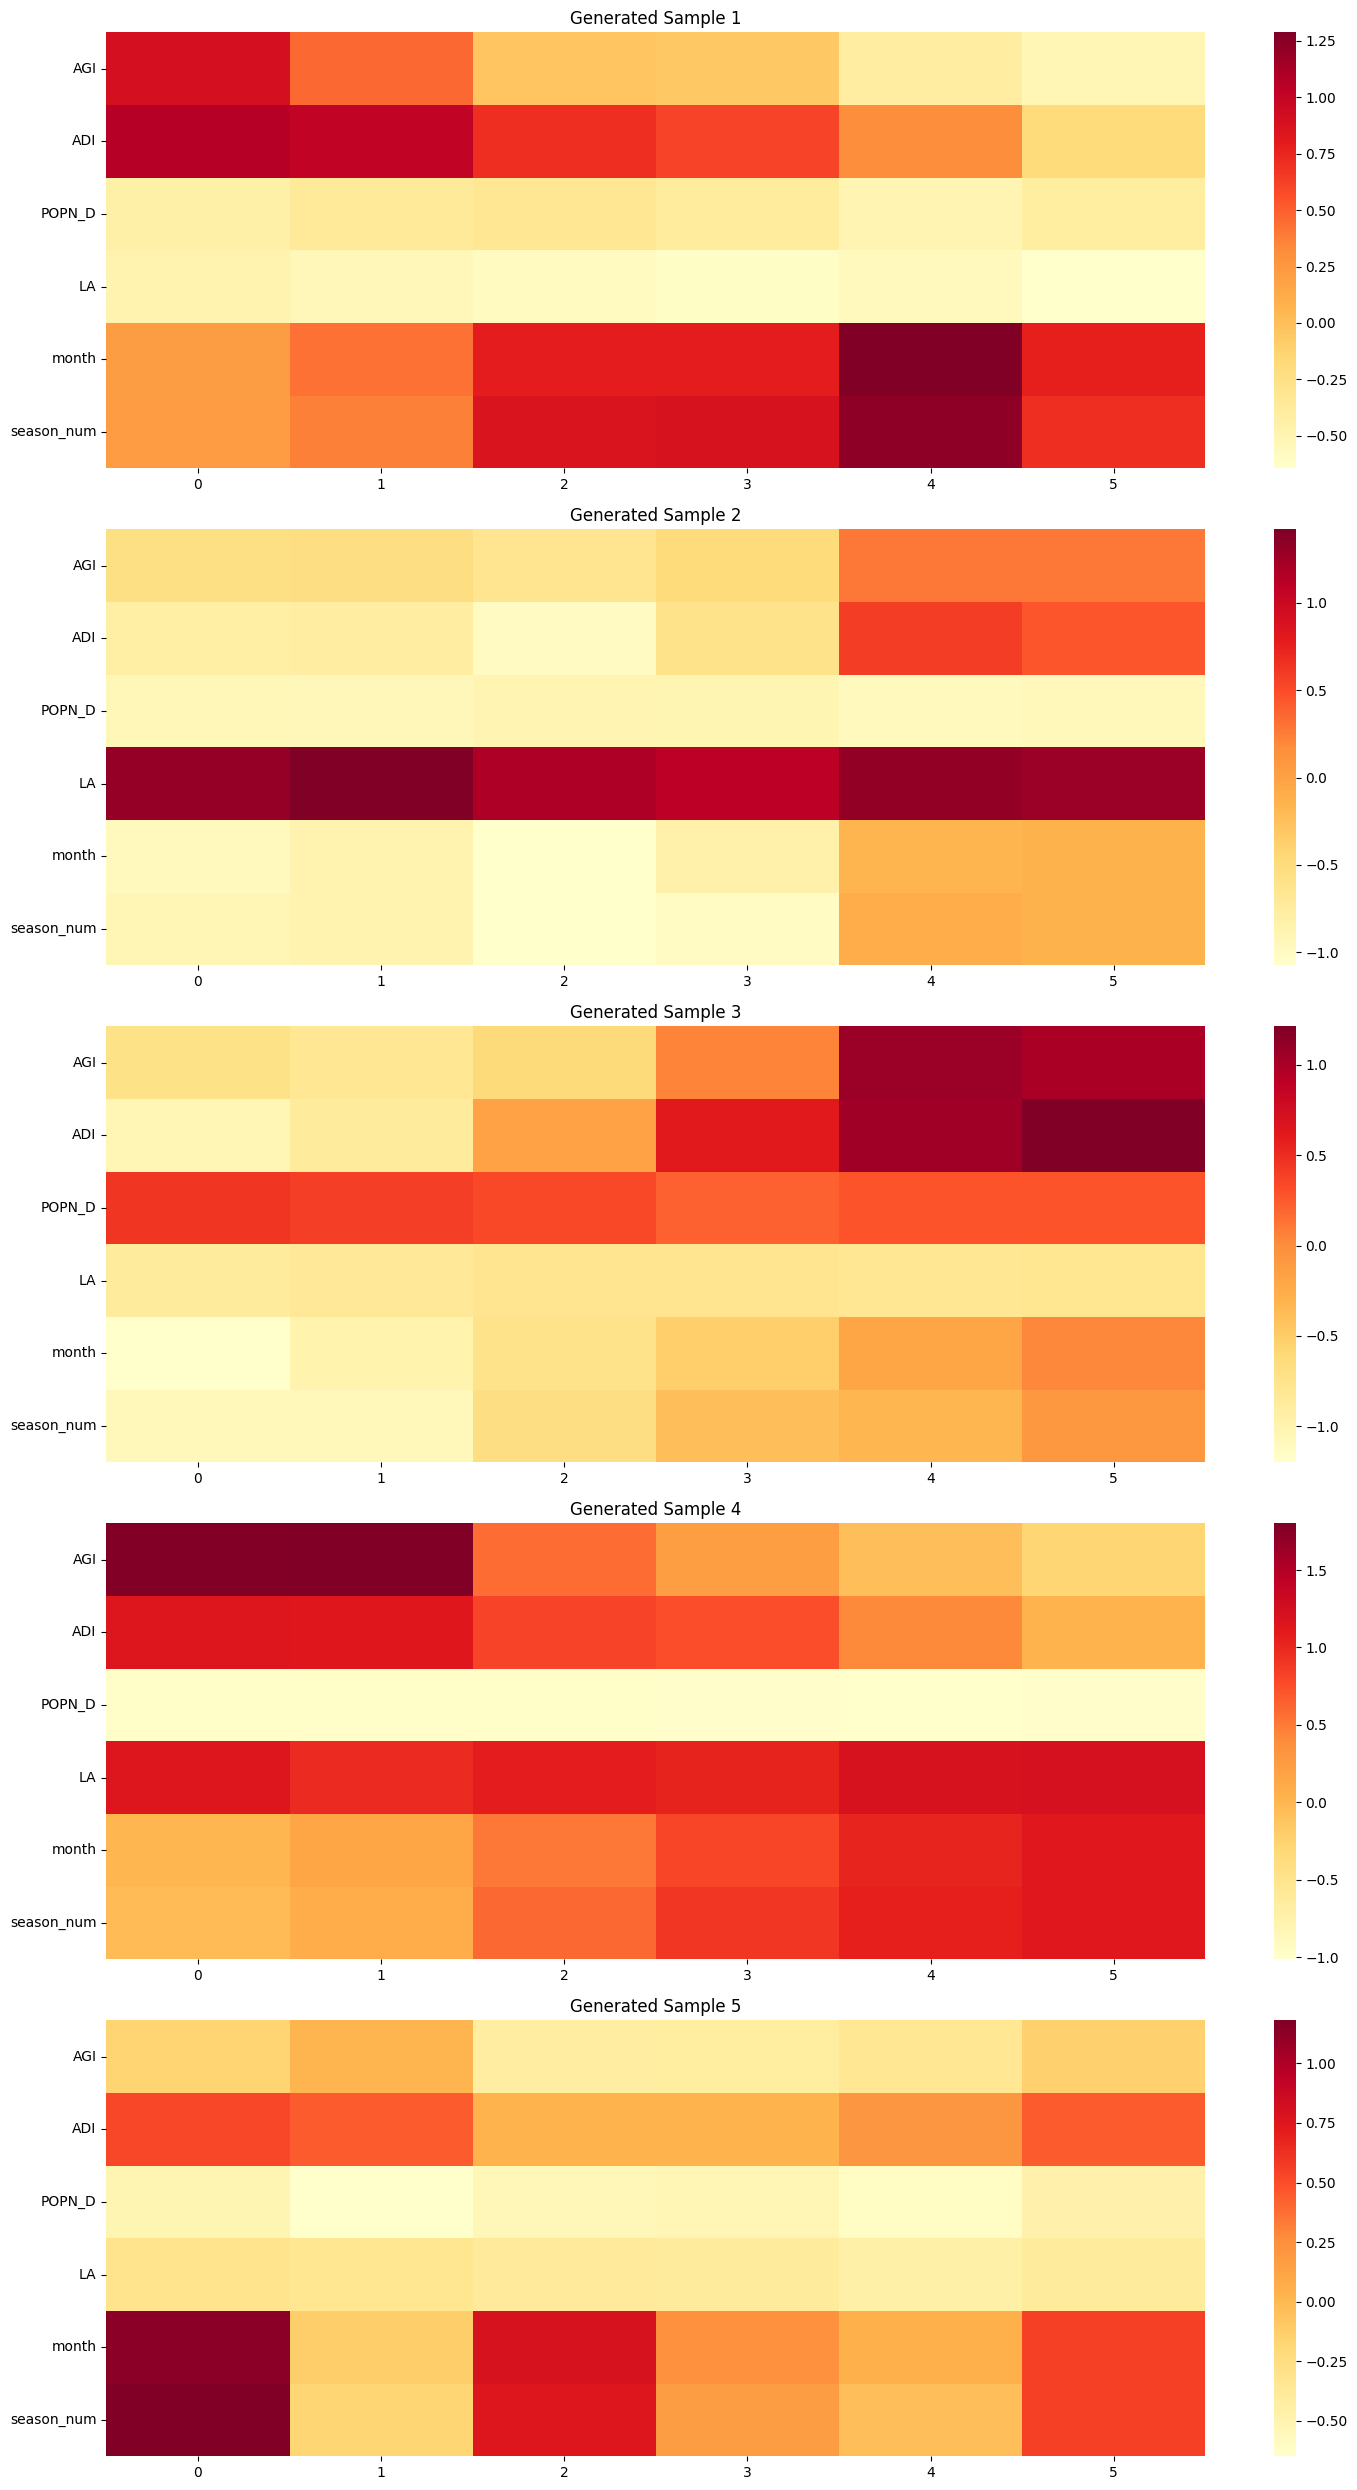

In [8]:
generate_and_visualize_samples(model_loader, n_samples=5)

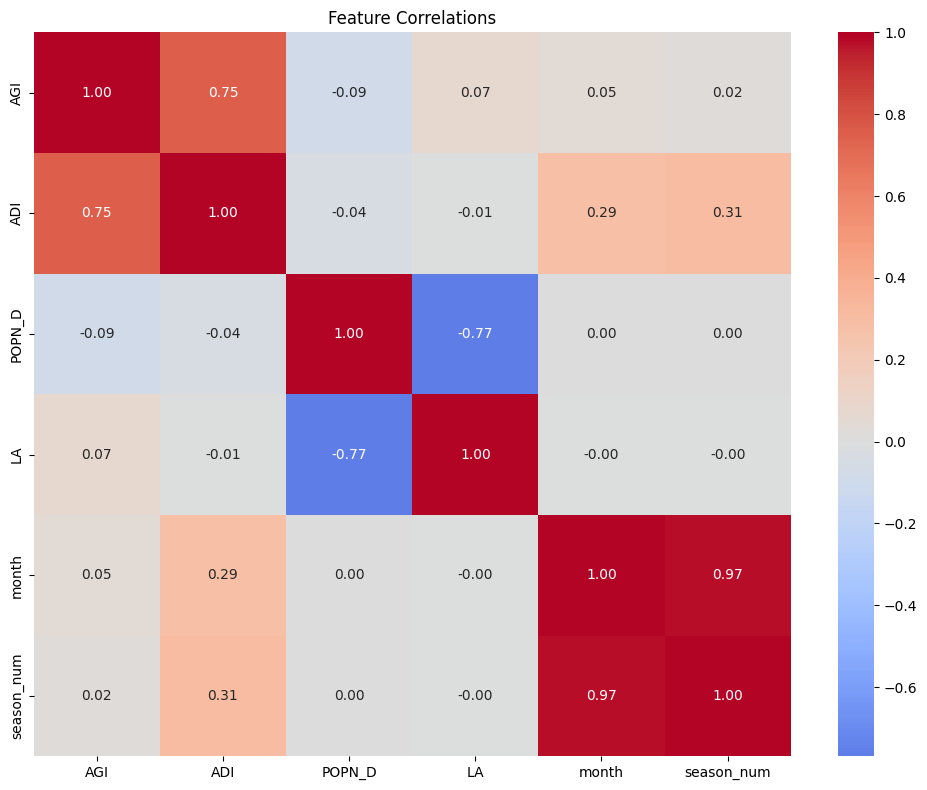

In [9]:
analyze_feature_correlations(model_loader)

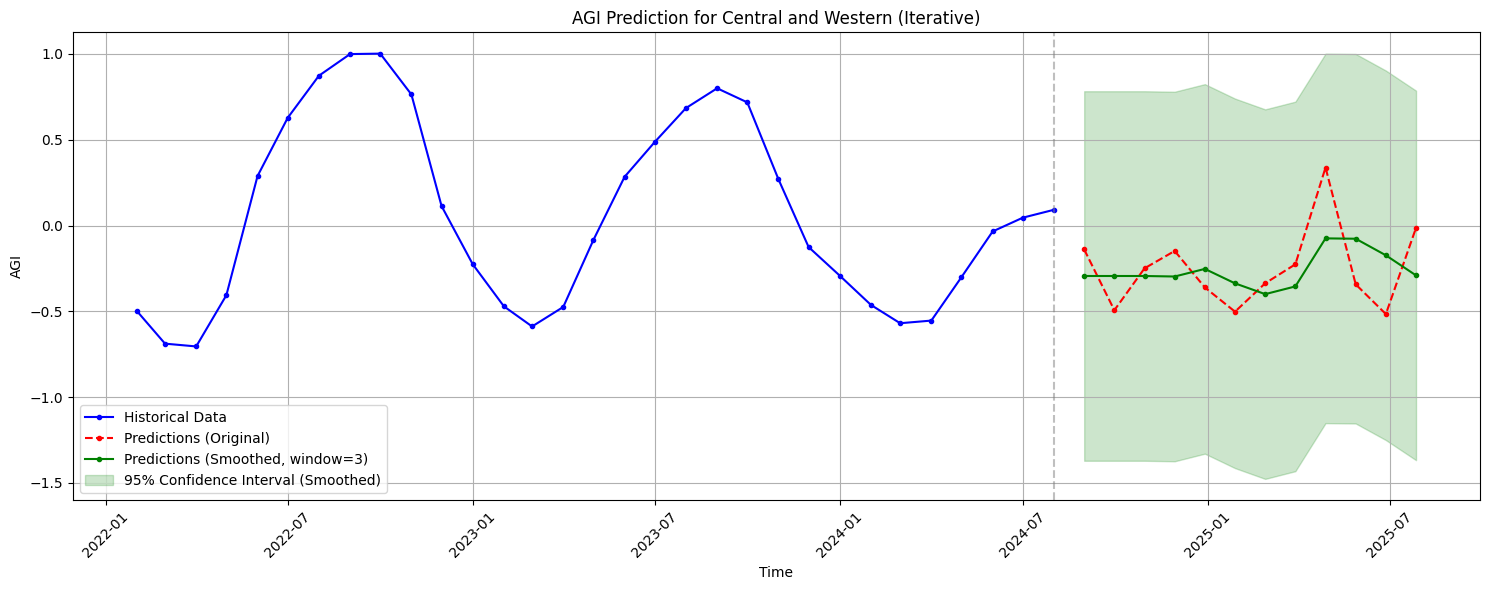


预测结果概要：
时间: 2024-08
预测值: -0.06 ± 0.29
时间: 2024-09
预测值: -0.22 ± 0.33
时间: 2024-10
预测值: -0.40 ± 0.37
时间: 2024-11
预测值: -0.43 ± 0.45
时间: 2024-12
预测值: -0.40 ± 0.37
时间: 2025-01
预测值: -0.33 ± 0.50
时间: 2025-02
预测值: -0.26 ± 0.44
时间: 2025-03
预测值: -0.23 ± 0.46
时间: 2025-04
预测值: -0.20 ± 0.50
时间: 2025-05
预测值: -0.20 ± 0.48
时间: 2025-06
预测值: -0.18 ± 0.49
时间: 2025-07
预测值: -0.21 ± 0.54


In [10]:
from utils.TimeSeriesPredictor import TimeSeriesPredictor
# 使用示例
predictor = TimeSeriesPredictor(model_loader)

# 预测并可视化单个地区的趋势（逐步预测）
district_name = "Central and Western"  # 替换为实际的地区名
historical, future_times, predictions,smooth_predictions = predictor.plot_predictions_iterative(
    district_name, feature_name='AGI', steps=12
)

# 分析预测的不确定性
mean_pred, std_pred = predictor.analyze_prediction_uncertainty_iterative(
    district_name, feature_name='AGI', steps=12, n_samples=100
)

# 打印预测结果
print("\n预测结果概要：")
for time, pred, std in zip(future_times, mean_pred, std_pred):
    print(f"时间: {time.strftime('%Y-%m')}")
    print(f"预测值: {pred:.2f} ± {2*std:.2f}")

In [11]:
# 使用示例
analyzer = GlobalTrendAnalyzer(model_loader, predictor)

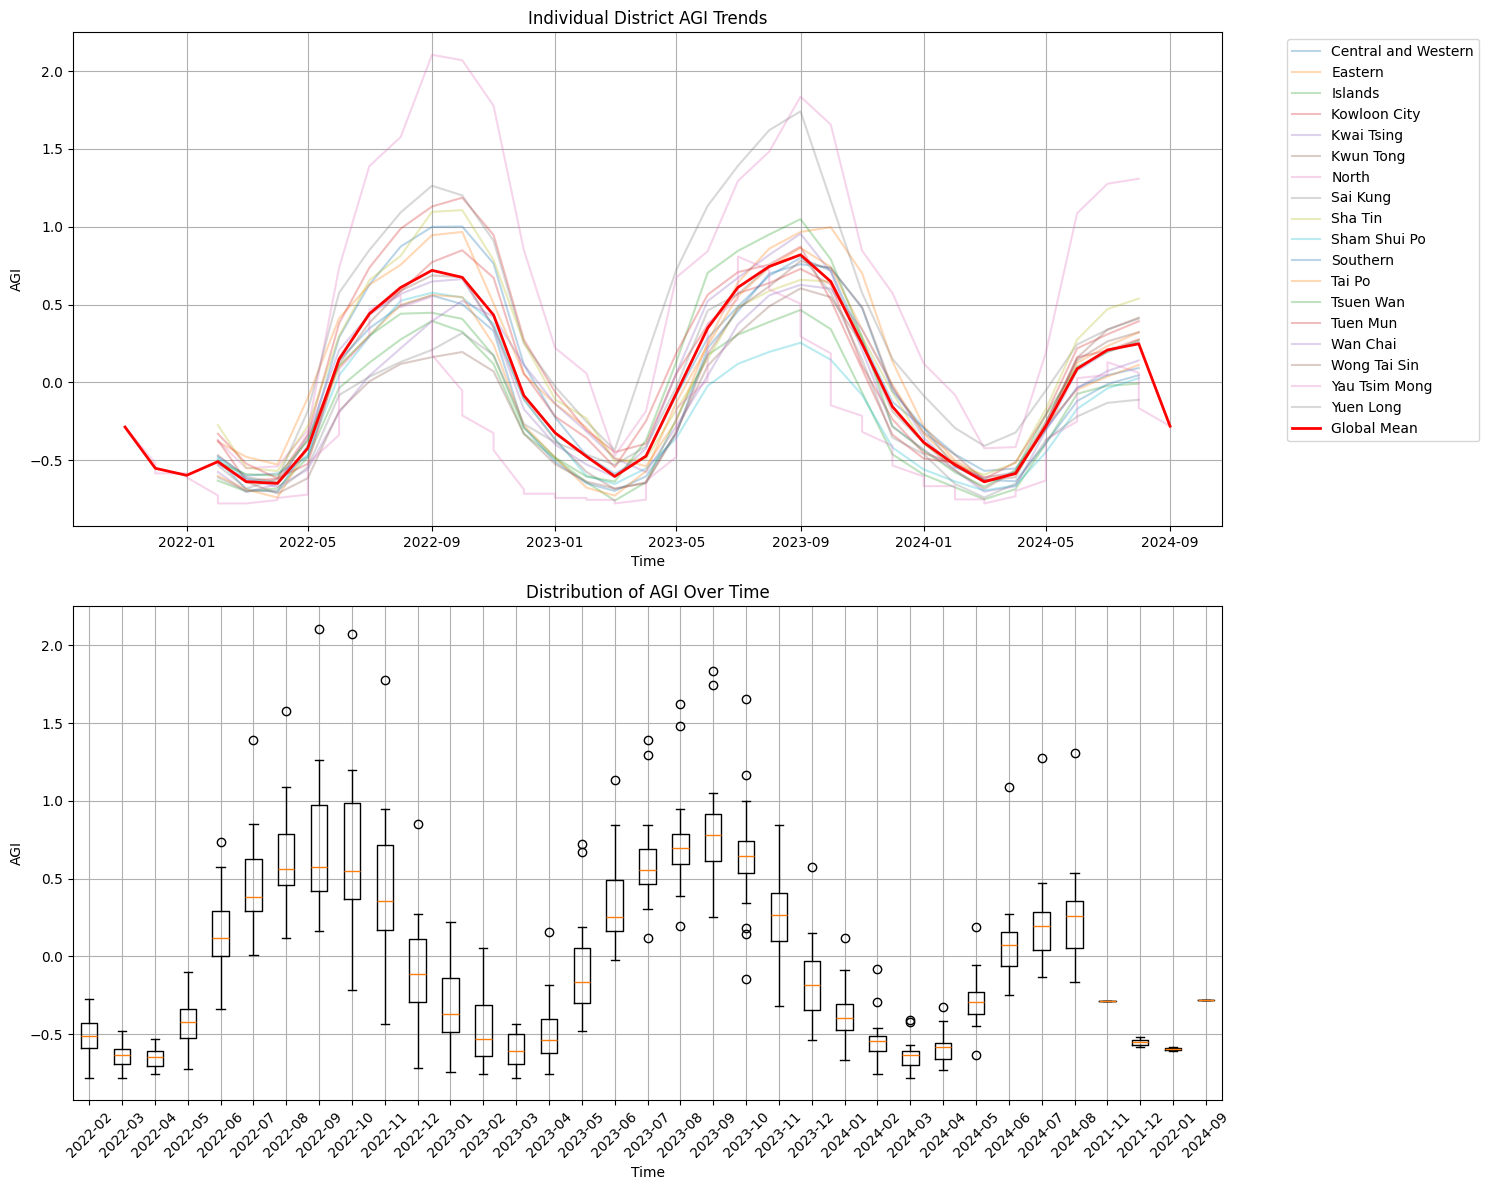

In [12]:
# 1. 分析历史趋势
global_trend = analyzer.analyze_global_trends(feature_name='AGI')

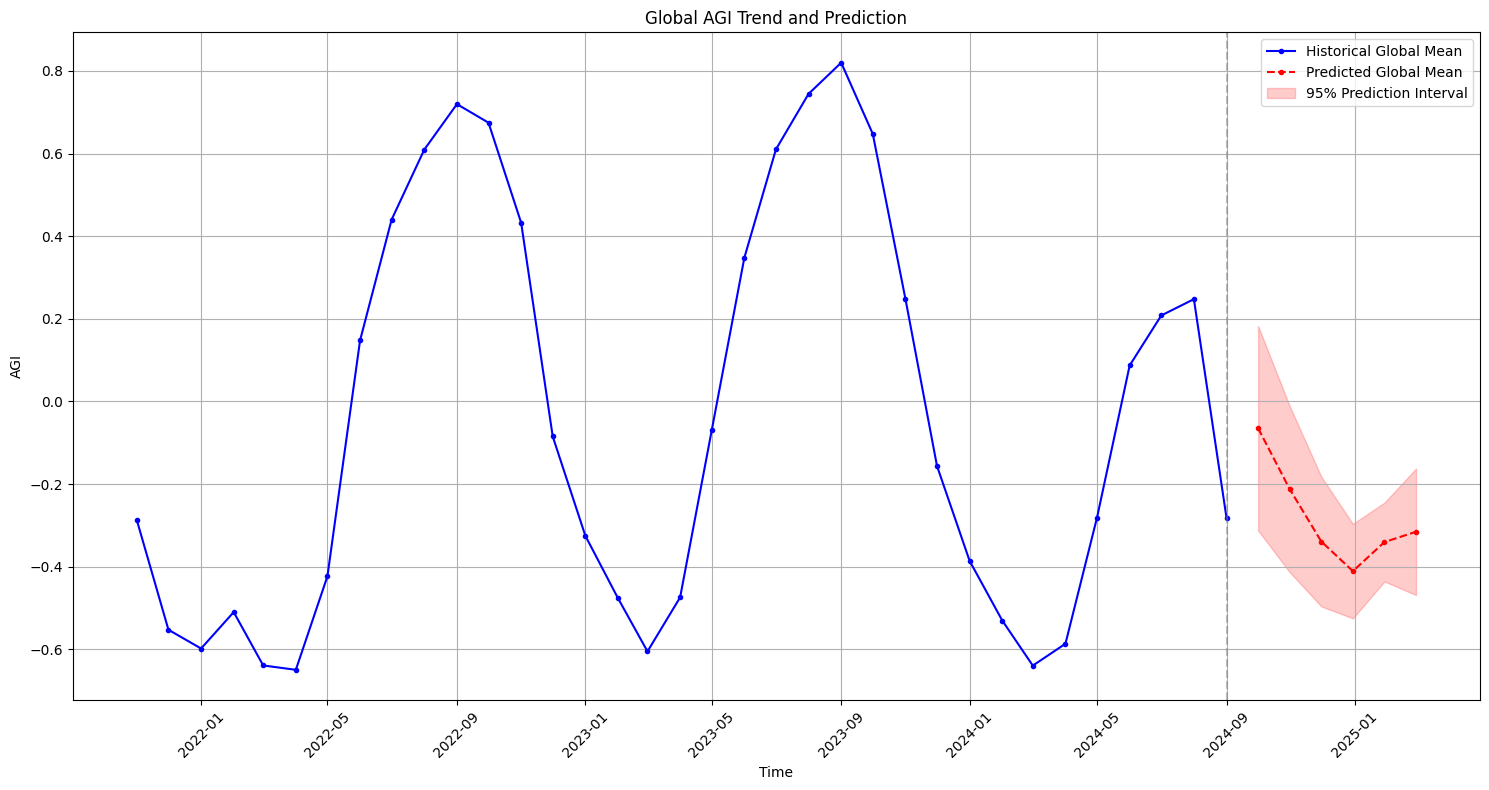

In [13]:
# 2. 预测总体趋势
global global_mean, global_std

historical, future_times, global_mean, global_std = analyzer.predict_global_trend(
    feature_name='AGI', steps=6, n_samples=100
)

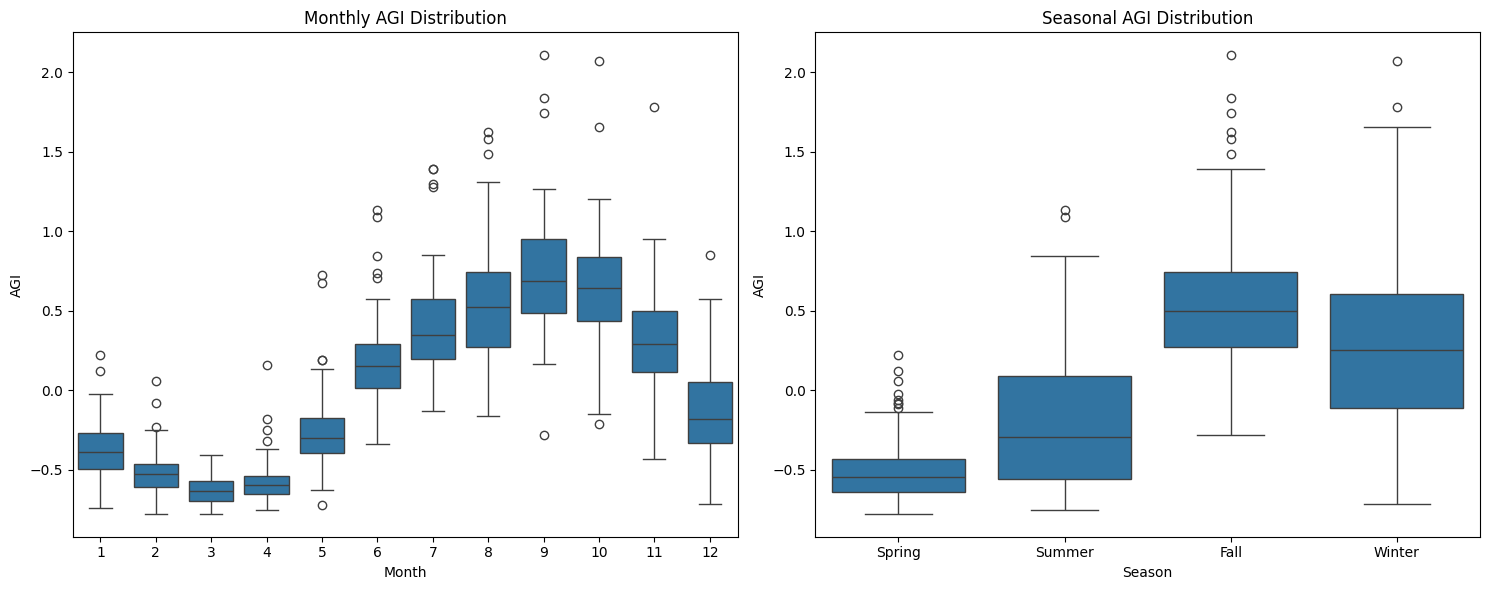

In [14]:
# 3. 分析季节性模式
seasonal_stats = analyzer.analyze_seasonal_patterns(feature_name='AGI')


=== AGI 趋势分析报告 ===

总体统计:
平均值: -0.00
标准差: 0.57
趋势斜率: 0.01


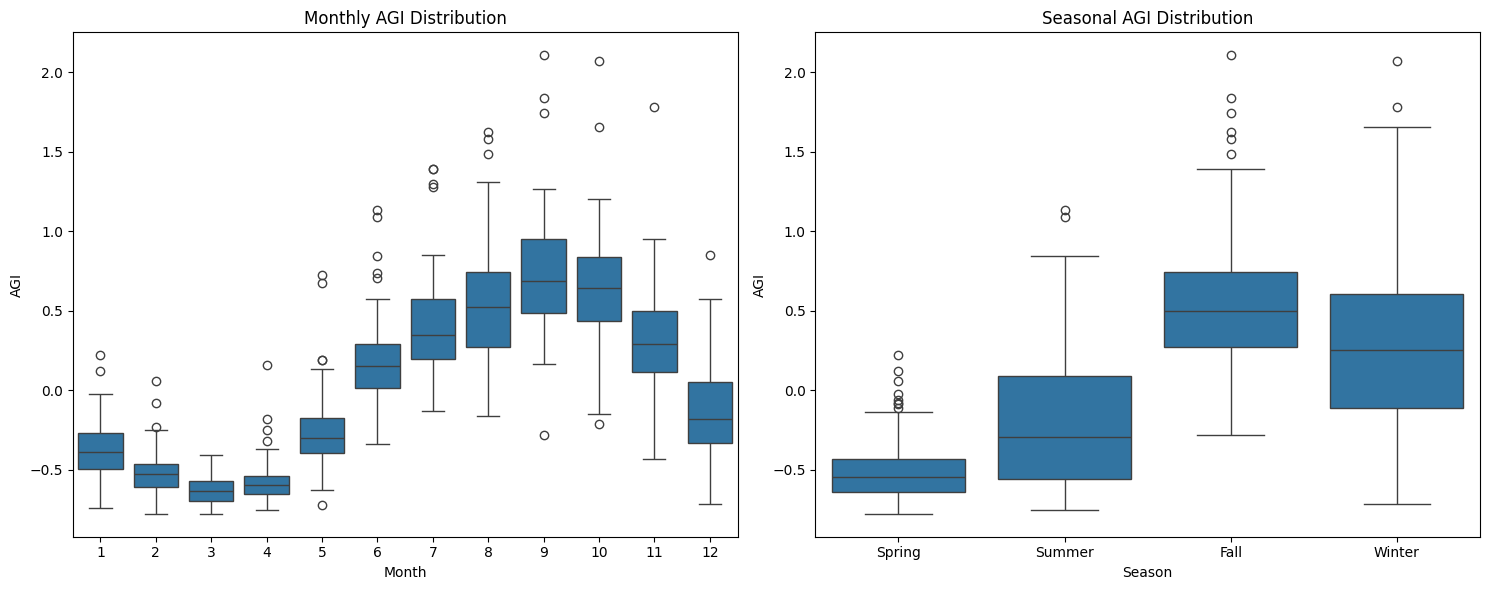


季节性统计:
            mean       std
season                    
Spring -0.514850  0.189849
Summer -0.211218  0.400374
Fall    0.544518  0.413265
Winter  0.274307  0.516885


In [15]:
# 4. 生成趋势报告
trend_report = analyzer.generate_trend_report(feature_name='AGI')

In [16]:
# 打印预测结果
print("\n全局预测结果：")
for time, mean, std in zip(future_times, global_mean, global_std):
    print(f"时间: {time.strftime('%Y-%m')}")
    print(f"预测值: {mean:.2f} ± {2*std:.2f}")


全局预测结果：
时间: 2024-10
预测值: -0.06 ± 0.25
时间: 2024-10
预测值: -0.21 ± 0.20
时间: 2024-11
预测值: -0.34 ± 0.16
时间: 2024-12
预测值: -0.41 ± 0.11
时间: 2025-01
预测值: -0.34 ± 0.10
时间: 2025-02
预测值: -0.32 ± 0.15
